In [1]:
%pylab inline
import sqlite3,copy,gc
import pandas as pd
import statsmodels.formula.api as sm
import numpy as np
import matplotlib.pyplot as plt 
from statsmodels.tsa.stattools import adfuller
import multiprocessing as mp
import time

Populating the interactive namespace from numpy and matplotlib


In [2]:
%%HTML
<button onclick="$('.input, .prompt, .output_stderr, .output_error, .output_result').toggle();">Toggle Code</button>

In [3]:
def InitalSqliteConnection(target):

    if target != 0:
        conn = sqlite3.connect(target)
    else:
        conn = sqlite3.connect(":memory:")

    return conn

def CollectedTableName(conn):
    #collect the name of table
    cur = conn.cursor()
    cur.execute(
        "select name from sqlite_master where type='table' order by name")
    return [table[0].encode("utf-8") for table in cur.fetchall()]

def InitialSelectData(databasefilepath):
    
    conn = InitalSqliteConnection(databasefilepath)
    tables = CollectedTableName(conn)
    return tables,conn
def ReturnRate(onelist):
    
    end=copy.deepcopy(onelist)
    onelist.pop()
    del end[0]
    temp = [bb-aa for (aa,bb) in zip(onelist,end)]
    temp.insert(0,"NAN")
    return temp
def DetectStatus(mas,prices):
    temp =zip(mas,prices)
    buy=[]
    for ma,price in temp:
        if price < ma:
            buy.append(1)
        else:
            buy.append(0)
    return buy
    

def variable2dummy(allll):
    temp=[]
    for al in allll:
        if al >0:
            temp.append(1)
        else:
            temp.append(0)
    return temp 
def GoogleSearchLevel(dfseries,df):
    level=[]
    for d in list(dfseries):
        if d<2:
            level.append(0)
      
        elif d < 25 and d>=2:
            level.append(1)
        elif d>=25 and d<50:
            level.append(2)
        elif d>=50 and d<75:
            level.append(3)
        else:
            level.append(4)
    df['GoogleSearch_level']=level
    return df
def NewsHeatLevel(dfseries,df):
    #if d < 0.20:
        #df['NewsHeat_level']=1
    #elif d>=1 and d<2:
    #    df['NewsHeat_level']=2
    #elif d>=2 and d<3:
    #    df['NewsHeat_level']=3
    #else:
        #df['NewsHeat_level']=2
    df['NewsHeat_level']=list(dfseries)
    return df
def CreateLevel(df,printout=False):
    replaceAbnormalValue(df['GoogleSearch'])
    replaceAbnormalValue(df['NEWS_HEAT_READ_DAVG'])
    
    if df['GoogleSearch'].describe()[1]>0:
        
        if printout!=False:
            print "Do ols regression for GoogleSearch"
        
            df['GoogleSearch'].hist(bins=20,alpha=0.5, color='k', normed=True)
            df['GoogleSearch'].plot(kind='kde', style='k--')
        else:
            pass
    else:
        pass
    
    df=GoogleSearchLevel(df['GoogleSearch'],df)
    
    if df['NEWS_HEAT_READ_DAVG'].describe()[1]>0:
        
        if printout!=False:
            print "do ols regression for NEWS_HEAT_READ_DAVG"
            df['NEWS_HEAT_READ_DAVG'].hist(alpha=0.5, color='red', normed=True)
            df['NEWS_HEAT_READ_DAVG'].plot(kind='kde', style='k--')
        else:
            pass
    
    else:
        pass
    if printout!=False:
        print "Mean of GoogleSearch for %s:"%table,df['GoogleSearch'].describe()[1]
        print "Mean of NEWS_HEAT_READ_DAVG for %s:"%table,df['NEWS_HEAT_READ_DAVG'].describe()[1]
    df=NewsHeatLevel(df['NEWS_HEAT_READ_DAVG'],df)
    return df
def replaceAbnormalValue(df):
    l =[s for s in set(df) if s<0]
    
    if len(l) != 0:
        temp=[0]*len(l)
        t =dict(zip(l,temp))
        df.replace(t,inplace=True)
    else:
        pass
def SelectDataforStats(df,table):
    temp_df =df[['PRC','Return','MARE30','MAP','GoogleSearch_level','NewsHeat_level']]
    a =dict(zip(['PRC','Return','MARE30','MAP','GoogleSearch_level','NewsHeat_level'],list(mean(temp_df))))
    a.update({"ticker":table})
    return a
def drawGraph(info_pd,target_variable,limited_variable):
    if len(set(info_pd[limited_variable]))>1:
        tests =[(s,info_pd[target_variable][info_pd[limited_variable]==s]) for s in set(info_pd[limited_variable])]
    else:
        s =set(info_pd[limited_variable])[0]
        tests =[(s,info_pd[target_variable][info_pd[limited_variable]==s])]
    for s,test in tests:
        if len(test)<=2:
            pass
        else:
            test.hist(bins=20,alpha=0.5, color='red', normed=True)
            test.plot(kind='kde', title='%s Under %s level =%s'%(target_variable,limited_variable,s),style='k--',label='Density Distribution',legend=True)
            plt.grid(True)  
            plt.show()
        
        
test_reg=pd.read_csv(dataForall+list_all[0])[['date','RET','PRC',u'MAP_5',
       u'MAP_10', u'MAP_20', u'MAP_30', u'MAP_60', u'MAP_100', u'MAP_200',u'Mkt-RF', u'SMB', u'HML', u'RF',u'NEWS_HEAT_READ_DAVG',u'GoogleSearch']]

def TestADFandProcessOther(df,printout=False,othertype="Diff",process=[]):
    (adf,p_value)=adftest(df,False)

    if p_value>=0.05:
        #print p_value
        if othertype=="Diff":
            process.append("Diff")
            (adf,p_value,process) = TestADFandProcessOther(df.diff(1)[1:],printout,"Diff",process)
        else:
            process.append("Log")
            (adf,p_value,process) = TestADFandProcessOther(log(df),printout,"Log",process)
    else:
        pass
    return (adf,p_value,process)

def Diff2DateFrame(df,n=1):
    return df.diff(n)[n:]
def Log2DateFrame(df):
    return log(df)
def DetectADFtestandReturnVarlist(df,Need_test):
    var_list=[]
    for var in Need_test:
        adf_result =TestADFandProcessOther(df[var],process=[])
        if len(adf_result[2])==0:
            var_list.append(var)
        else:

            df['%sDiff%s'%(var,len(adf_result[2]))]=Diff2DateFrame(df['%s'%var],len(adf_result[2]))
            var_list.append('%sDiff%s'%(var,len(adf_result[2])))

    #print var,adf_result[2]
    #print adf_result
    #price_adf,price_adf_p=adftest(df['PRC'].diff(1)[1:],True)
    #google_adf,google_adf_p=adftest(df['GoogleSearch'],True)
    #adf_result =TestADFandProcessOther(df['GoogleSearch'],process=[])
    #print adf_result[2] 
    return var_list
def ReturnOlsCMD(x_var_list,x,y_var_list):
    xa=copy.deepcopy(x_var_list)
    ya=copy.deepcopy(y_var_list)
    xa.append(x)
    ya.extend(xa)
    return ya
def OlsTestProcess(NewsHeat,GoogleSearch,df):
    result_bloomberg = sm.ols(formula="%s ~ %s+%s+%s+%s+%s"%(NewsHeat[0],NewsHeat[1],NewsHeat[2],NewsHeat[3],NewsHeat[4],NewsHeat[5]), data=df).fit()
    result_googlesearch = sm.ols(formula="%s ~ %s+%s+%s+%s+%s"%(GoogleSearch[0],GoogleSearch[1],GoogleSearch[2],GoogleSearch[3],GoogleSearch[4],GoogleSearch[5]), data=df).fit()
    #result_googlesearch = sm.ols(formula="MAP ~VOL+MktRF+SMB+HML+GoogleSearch", data=df).fit()
    #print result_bloomberg.params
    #print result_bloomberg.summary()

    #print result_googlesearch.params,result_googlesearch.pvalues
    #print result_bloomberg.params
    #print result_bloomberg.pvalues[-1]
    #print result_bloomberg.f_pvalue
    #print result_bloomberg.summary()
    return result_bloomberg,result_googlesearch
def varlist(df,x_Need_test,y_Need_test,x_Attention_Need_test):
    
    x_var_list=DetectADFtestandReturnVarlist(df,x_Need_test)
    #varlist.extend(x_var_list)
    y_var_list=DetectADFtestandReturnVarlist(df,y_Need_test)
    #varlist.extend(y_var_list)
    x_Attention_var_list=DetectADFtestandReturnVarlist(df,x_Attention_Need_test)
    
    #x_var_list,y_var_list
    #print x_var_list,y_var_list,x_Attention_var_list,TestADFandProcessOther(df['NEWS_HEAT_READ_DAVG'],process=[])[2]
    
    #print DetectADFtestandReturnVarlist(df,x_Need_test)
    return x_var_list,y_var_list,x_Attention_var_list
def pdmerge(a,b):
    return pd.merge(a,b,how='outer',sort=False)
def pdjoin(a,*b):
    return a.join(*b,on="Date",how='outer',sort=False)
def mergeDateFrame(*b):
    return reduce(pdmerge,*b)
def RefineDataFrame_backup(rr):
    rr['Date'] = DetecteAbnormalValue(rr['Date'],nagetive='abs',unwantedstr=1,dtype=np.int64)
    rr['PRC'] = DetecteAbnormalValue(rr['PRC'],nagetive='abs',unwantedstr=1,dtype=np.float64,fillna='mean')
    rr['RET'] = DetecteAbnormalValue(rr['RET'],nagetive=0,unwantedstr=1,dtype=np.float64,fillna='mean')
    rr['VOL'] = DetecteAbnormalValue(rr['VOL'],nagetive='abs',unwantedstr=1,dtype=np.int64)
    rr['SICCD'] = DetecteAbnormalValue(rr['SICCD'],nagetive='abs',unwantedstr=1,dtype=np.int64)

    rr =rr.sort(['Date']).reset_index()
    rr.drop('index',axis=1, inplace=True)
    return rr
def RefineDataFrame(rr,paramslist,sort='Date'):
    for key,value in paramslist.items():
        rr[key] = DetecteAbnormalValue(rr[key],nagetive=value[0],unwantedstr=value[1],dtype=value[2],fillna=value[3])
    if sort != False:
        if sort in list(rr.columns):
            rr=rr.sort([sort]).reset_index()
            rr.drop('index',axis=1, inplace=True)
        else:
            pass
    else:
        pass
    return rr
def DetecteAbnormalValue(dfseries,nagetive='fillzero',unwantedstr=0,dtype=False,fillna="dontfill"):
    
    #unwanted str
    if unwantedstr !=False:
    
        dfseries=pd.to_numeric(dfseries,errors='coerce')
        
    else:
        pass
    #negative value
    if nagetive =='fillzero':
        abnormal_nagtive=[i for i in set(dfseries) if i <0]
        if abnormal_nagtive != []:
            dfseries.replace(abnormal_nagtive,0)
        else:
            pass
        
    elif nagetive == 'abs':
        dfseries = abs(dfseries)
        
    else:
        pass
    
    if fillna == "dontfill":
        pass
        
    elif fillna=='mean':
        dfseries=dfseries.fillna(dfseries.mean())
    elif fillna=='max':
        dfseries=dfseries.fillna(dfseries.max())
    else:
        dfseries=dfseries.fillna(fillna)
    
    
    
    if dtype != False:
        dfseries=dfseries.astype(dtype)
    else:
        pass
    return dfseries

In [4]:
target='output_oringal.db'
tables,conn =InitialSelectData(target)

x_Need_test=['VOL','MktRF','SMB','HML']
#x_Need_test=['VOL','MktRF']
x_Attention_Need_test=['GoogleSearch','NEWS_HEAT_READ_DAVG']
y_Need_test=['MAP']

In [15]:
variables = ['GoogleSearch_level','NewsHeat_level','MARE30','PRC','SICCD','TBill1Mo','Date','Return']
variables.extend(x_Need_test)
variables.extend(x_Attention_Need_test)
variables.extend(y_Need_test)
Dataset={} 
info=[]
for table in tables:
    df =pd.read_sql_query("select * from %s"%table,conn)
    col =list(df.columns)

    if 'Mkt-RF' in col:

        location = col.index('Mkt-RF') 
        col[location] = 'MktRF'

        df.columns =col
    else:
        pass
    #df.columns
    df=CreateLevel(df,printout=False)
    
    info.append(SelectDataforStats(df,table))
    df= df[variables]
    Dataset.update({table:df})
    

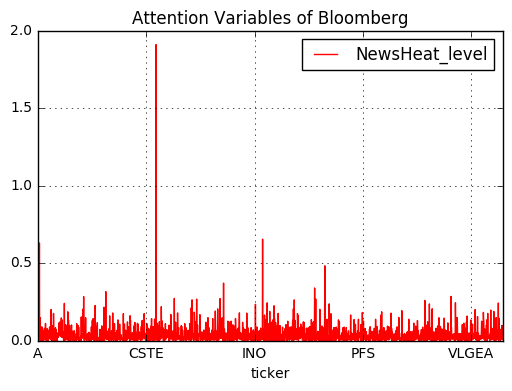

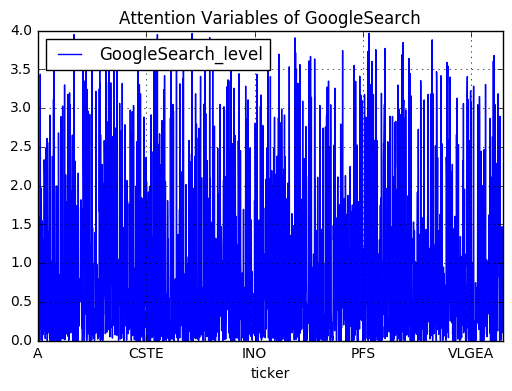

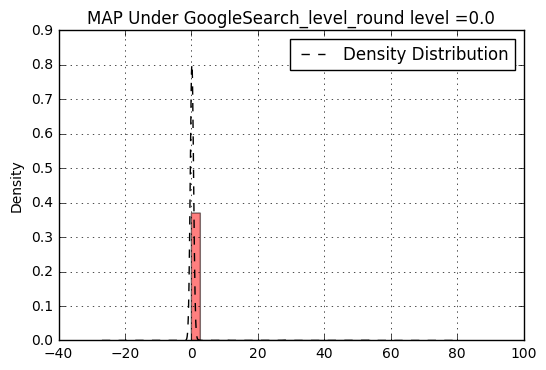

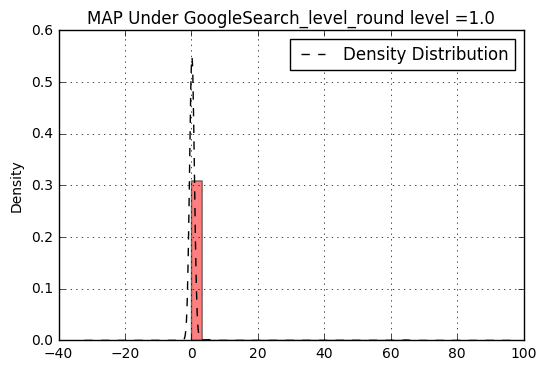

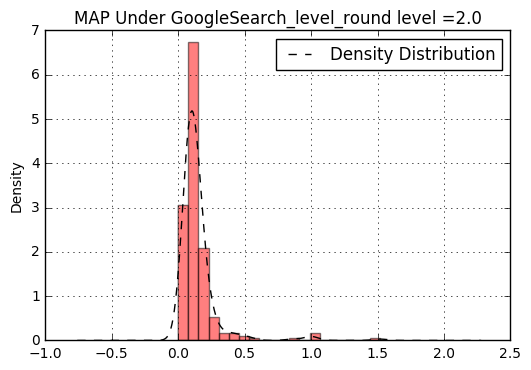

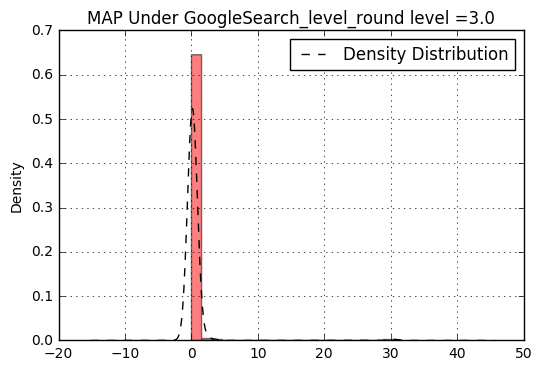

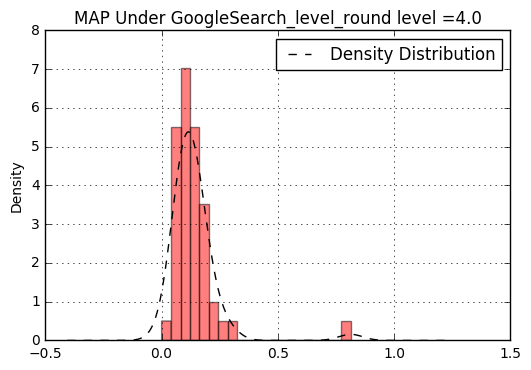

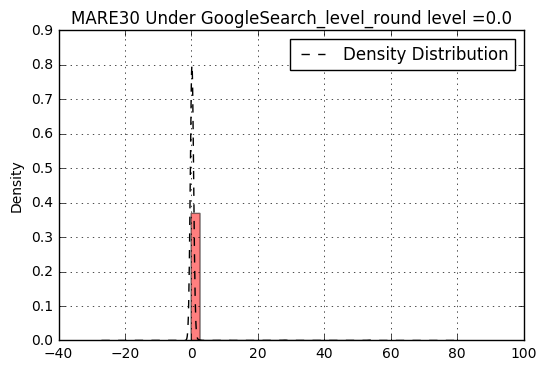

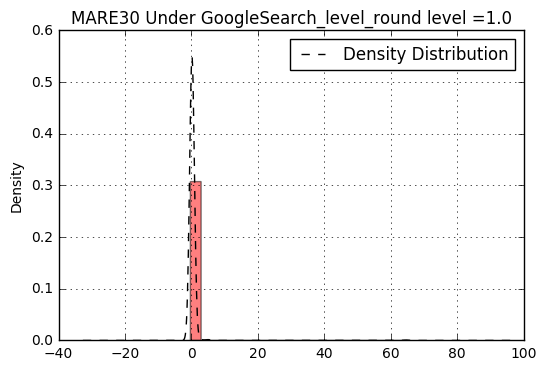

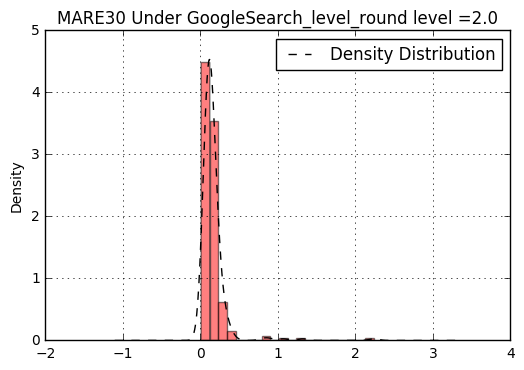

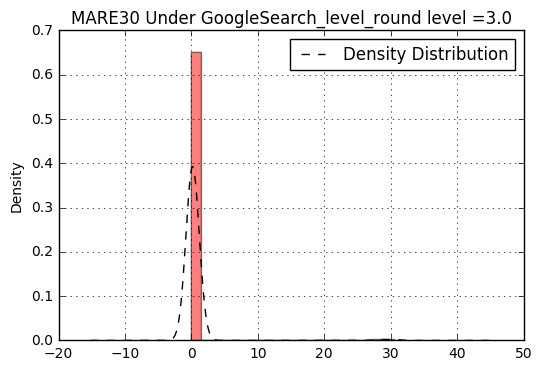

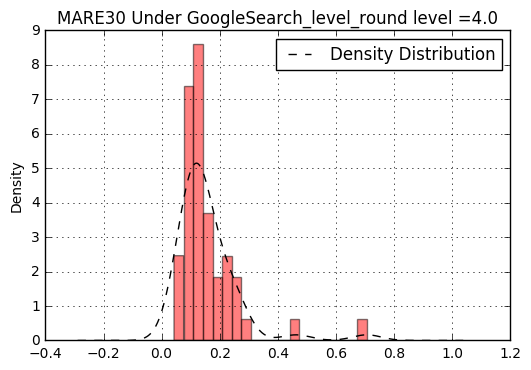

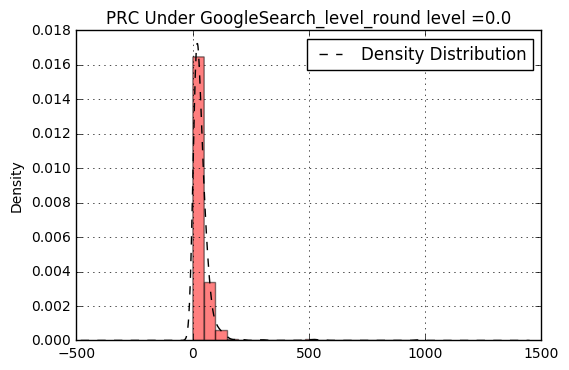

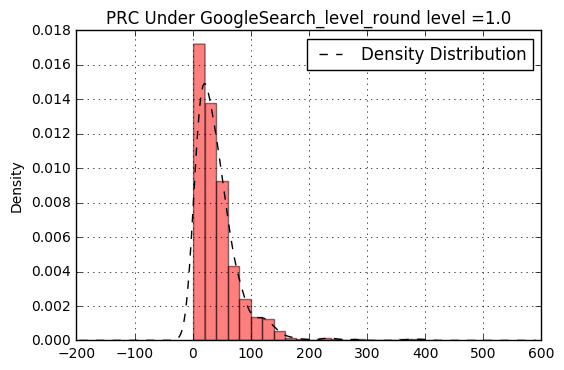

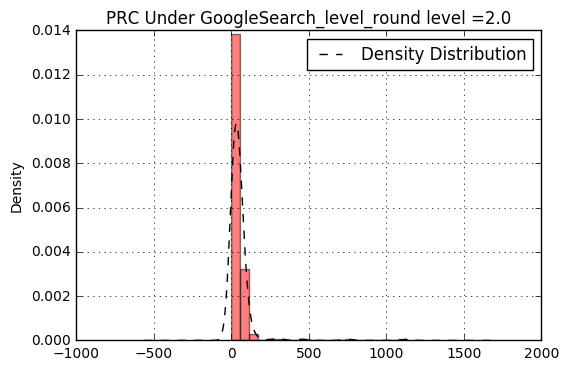

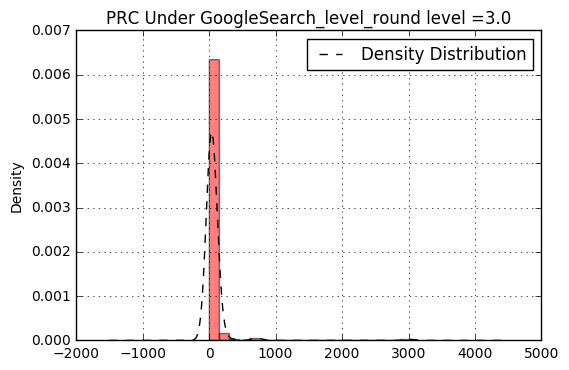

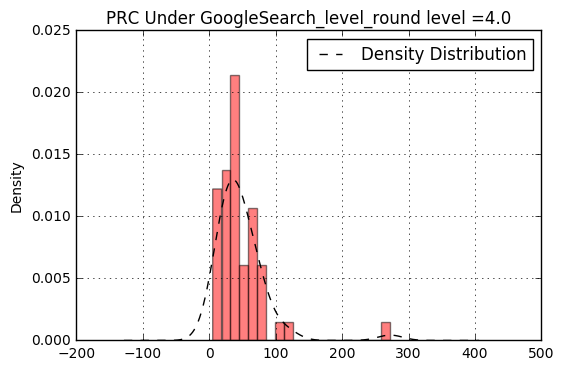

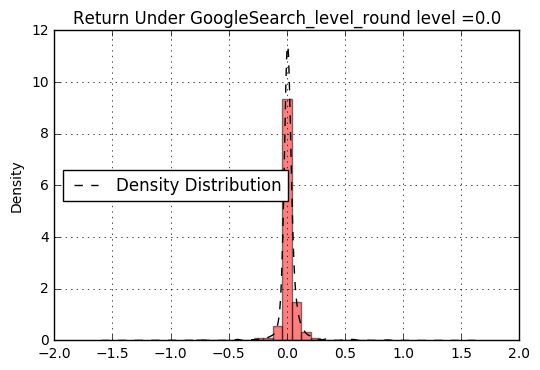

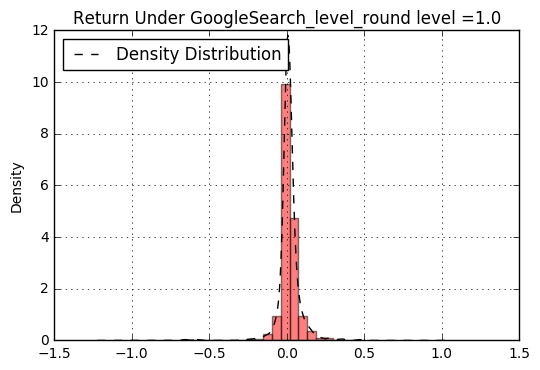

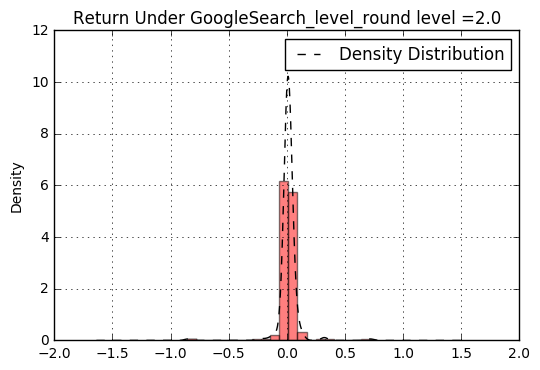

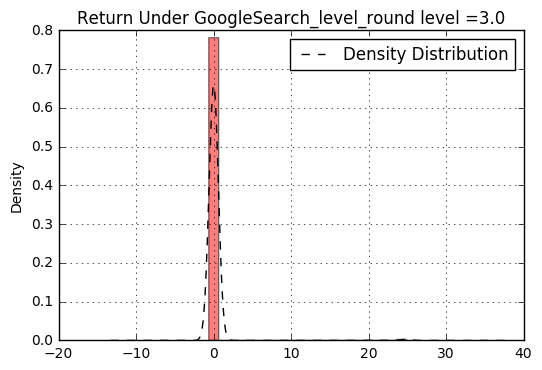

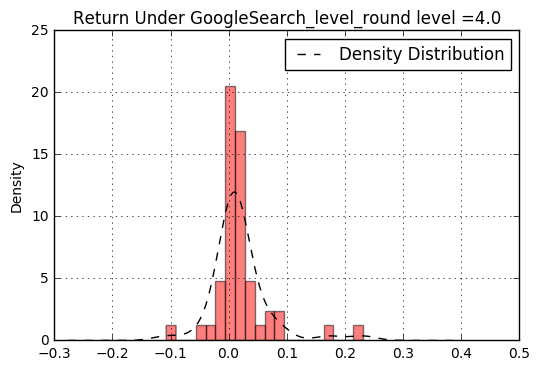

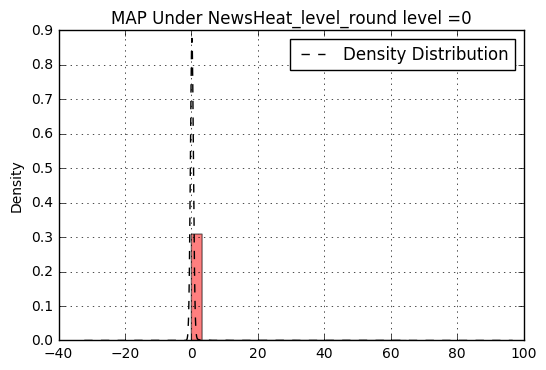

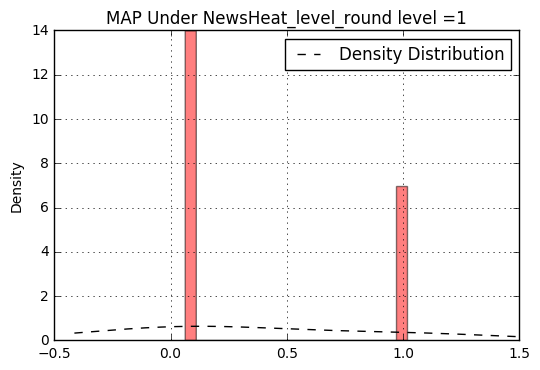

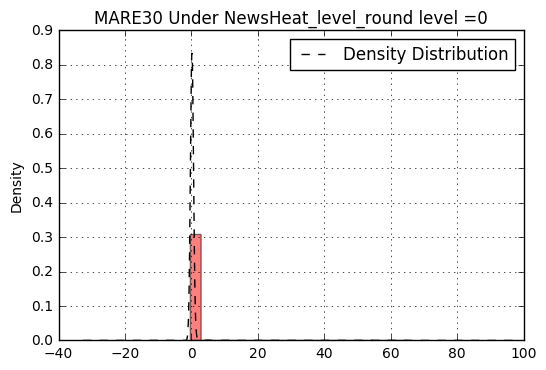

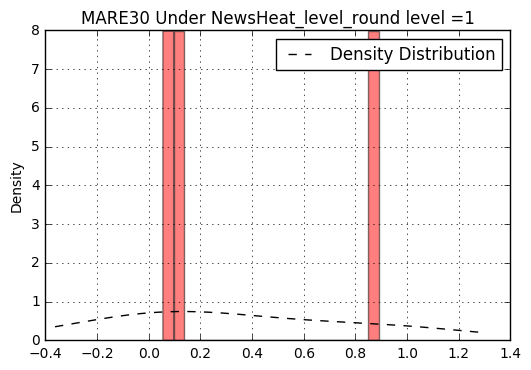

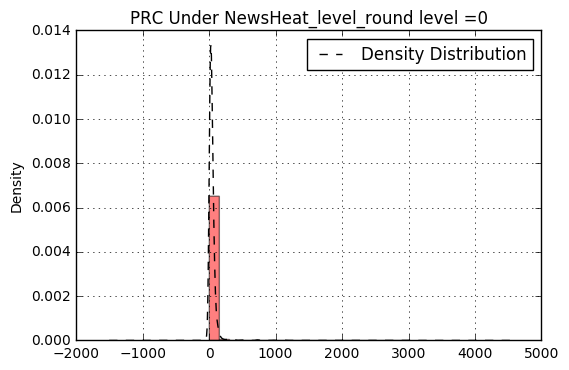

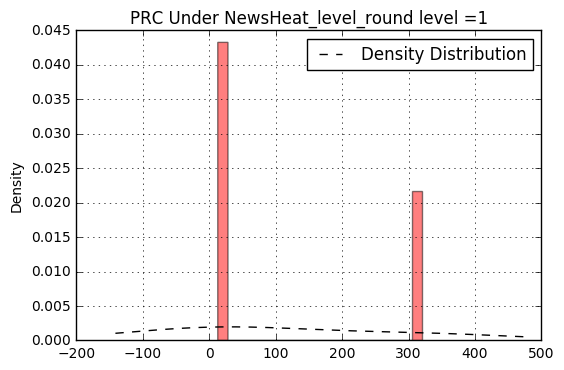

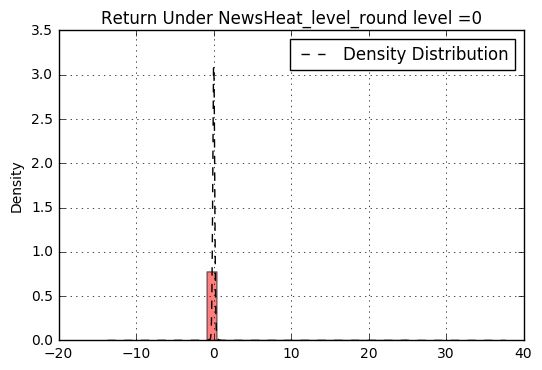

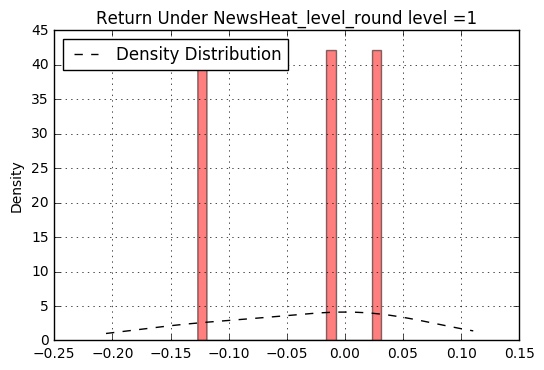

nan

In [16]:
#All Sample Data Information
info_pd=pd.DataFrame(info).set_index('ticker')
info_pd.dropna(inplace=True)


#for s in set(info_pd['GoogleSearch_level']):
#         print info_pd[info_pd['GoogleSearch_level']==s].describe()
#info_pd['GoogleSearch_level'] = info_pd['GoogleSearch_level'].round()
#info_pd['NewsHeat_level']=info_pd['NewsHeat_level'].round()
info_pd['NewsHeat_level'].plot(title='Attention Variables of Bloomberg',legend=True,colors="red")
plt.grid(True)  
plt.show()
info_pd['GoogleSearch_level'].plot(title='Attention Variables of GoogleSearch',legend=True)
plt.grid(True)  
plt.show()
info_pd['GoogleSearch_level_round']=info_pd['GoogleSearch_level'].round()

round_level=[]
for level in tuple(info_pd['NewsHeat_level']):
    if level >=0.5:
        round_level.append(1)
    else:
        round_level.append(0)
info_pd['NewsHeat_level_round']=round_level
 
    
#info_pd['MAP'][info_pd['GoogleSearch_level']==1].plot(kind='kde', title='GoogleTrends level =1',style='k--',label='Density Distribution',legend=True)
if 1==1:
    
    for target in ['MAP','MARE30','PRC','Return']:
        drawGraph(info_pd,target,'GoogleSearch_level_round')

    for target in ['MAP','MARE30','PRC','Return']:
        drawGraph(info_pd,target,'NewsHeat_level_round')

#subset.plot(subplots=True, figsize=(12, 10), grid=False, title="Number of births per year", xticks=range(1880, 2020, 10))
info_pd['NewsHeat_level'].value_counts()


#description



info_pd['MAP'][info_pd['GoogleSearch_level']==1].skew()
info_pd['MAP'][info_pd['GoogleSearch_level']==2].skew()
info_pd['MAP'][info_pd['GoogleSearch_level']==3].skew()
info_pd['MAP'][info_pd['GoogleSearch_level']==4].skew()


In [7]:
pivottableGS =pd.pivot_table(info_pd,index=['GoogleSearch_level_round'],values=['MAP','MARE30','PRC','Return'],
               aggfunc=[np.sum,np.mean,np.std],margins=True)  

print 'The Pivot table For Google Search Index'
pivottableGS
        


The Pivot table For Google Search Index


sum                                       \
                                 MAP      MARE30           PRC     Return   
GoogleSearch_level_round                                                    
0.0                       236.686935  254.004853  37086.676052  17.317918   
1.0                       170.496034  180.184475  26826.353726   9.688441   
2.0                        35.892771   39.346636  12153.776616   3.453865   
3.0                        67.697810   94.996791  13210.527732  27.298981   
4.0                         6.789100    7.735460   2366.579683   0.946360   
All                       517.562649  576.268214  91643.913809  58.705565   

                              mean                                      std  \
                               MAP    MARE30        PRC    Return       MAP   
GoogleSearch_level_round                                                      
0.0                       0.232502  0.249514  36.430920  0.017012  1.931851   
1.0                       0.271923  0.287376  42.785253  0.015452  2.588171   
2.0                       0.145906  0.159946  49.405596  0.014040  0.159389   
3.0                       0.330233  0.463399  64.441599  0.133166  2.133171   
4.0                       0.138553  0.157867  48.297545  0.019313  0.112742   
All                       0.241288  0.268657  42.724435  0.027369  2.040270   

                                                          
                            MARE30         PRC    Return  
GoogleSearch_level_round                                  
0.0                       1.934892   51.615641  0.081133  
1.0                       2.585061   40.953190  0.069752  
2.0                       0.189008   93.696546  0.085648  
3.0                       2.875388  221.826503  1.736479  
4.0                       0.109019   41.242722  0.049866  
All                       2.126376   86.850139  0.541658

In [8]:
pivottableBG =pd.pivot_table(info_pd,index=['NewsHeat_level_round'],values=['MAP','MARE30','PRC','Return'],
               aggfunc=[np.sum,np.mean,np.std],margins=True) 


print 'The Pivot table For Bloomberg News Heat Index'
pivottableBG

The Pivot table For Bloomberg News Heat Index


sum                                       \
                             MAP      MARE30           PRC     Return   
NewsHeat_level_round                                                    
0                     516.405867  575.214748  91295.554138  58.808881   
1                       1.156782    1.053467    348.359671  -0.103316   
All                   517.562649  576.268214  91643.913809  58.705565   

                          mean                                       std  \
                           MAP    MARE30         PRC    Return       MAP   
NewsHeat_level_round                                                       
0                     0.241086  0.268541   42.621641  0.027455  2.042100   
1                     0.385594  0.351156  116.119890 -0.034439  0.546513   
All                   0.241288  0.268657   42.724435  0.027369  2.040270   

                                                      
                        MARE30         PRC    Return  
NewsHeat_level_round                                  
0                     2.128311   86.718374  0.542153  
1                     0.467504  177.417116  0.082165  
All                   2.126376   86.850139  0.541658

In [86]:

#sample graph table
print df
##df['PRC'].plot(legend=True)
#df.MAP.plot(legend=True,colors="ORANGE",title='Smaple Graph: Ticker=%s'%table)
#df.MA_30.plot(legend=True)
#df.GoogleSearch.plot(legend=True,colors="red")
#df.NEWS_HEAT_READ_DAVG.plot(legend=True)

#df['MAP'].diff(1)[1:].plot()

Empty DataFrame
Columns: [GoogleSearch_level, NewsHeat_level, MARE30, PRC, SICCD, TBill1Mo, Date, Return, VOL, MktRF, SMB, HML, GoogleSearch, NEWS_HEAT_READ_DAVG, MAP]
Index: []


In [74]:
#ols
target_variable_list={}
target_result_list={}

for key,df in Dataset.items():
    
    df.dropna()
    if df.empty:
        pass
    
    else:
        try:
            #print key
            (x_var_list,y_var_list,x_Attention_var_list) =varlist(df,x_Need_test,y_Need_test,x_Attention_Need_test)
            #print df



            #print ReturnOlsCMD(x_var_list,'GoogleSearch',y_var_list)

            #OLS test1

            GoogleSearch =ReturnOlsCMD(x_var_list,'GoogleSearch',y_var_list)
            NewsHeat=ReturnOlsCMD(x_var_list,'NEWS_HEAT_READ_DAVG',y_var_list)
            #print GoogleSearch,NewsHeat
            #result_bloomberg,result_googlesearch =OlsTestProcess(NewsHeat,GoogleSearch,df)
            bloomberg,googlesearch =OlsTestProcess(NewsHeat,GoogleSearch,df)

            target_variable_list[key]={"GSpvalue":googlesearch.pvalues[-1],
                                       "BGpvalue":bloomberg.pvalues[-1],
                                          "GScoef":googlesearch.params[-1],
                                        "BGcoef":bloomberg.params[-1]
                                      }
            target_result_list[key]={"Result":(googlesearch,bloomberg)}
        except Exception as e:
            print e
            pass
    

    


maxlag should be < nobs
maxlag should be < nobs
maxlag should be < nobs
maxlag should be < nobs
maxlag should be < nobs
maxlag should be < nobs
maxlag should be < nobs
maxlag should be < nobs
maxlag should be < nobs
maxlag should be < nobs
maxlag should be < nobs
maxlag should be < nobs
maxlag should be < nobs
maxlag should be < nobs
maxlag should be < nobs
maxlag should be < nobs
maxlag should be < nobs
maxlag should be < nobs


Total Samples: 2651 ; Total Regression Number: 1846 

Google Search Available Sample (p<5%): 293 ; Available Rate: 0.15872156013
Mean of Google Search  coeff: -0.0257582877006


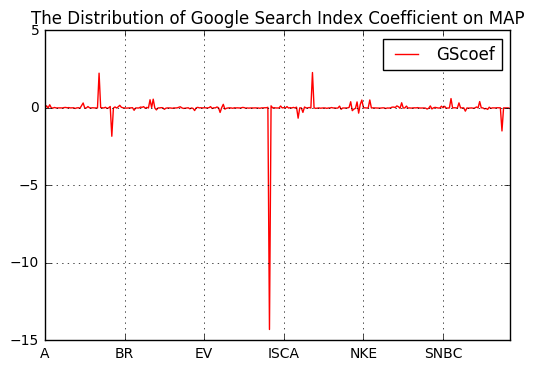

Bloomberg News Heat Available Sample (p<5%): 909 ; Available Rate: 0.49241603467
Mean of Bloomberg News Heat coeff: 0.590589912456


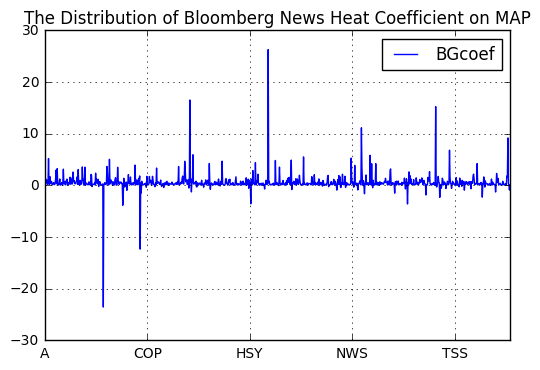

In [75]:
#result show
daad =pd.DataFrame(target_variable_list).T
alldata =daad.count()[1]
print 'Total Samples:',len(Dataset.keys()),'; Total Regression Number:',alldata,'\n'
GS=daad[daad['GSpvalue']<0.05].count()[3]
print "Google Search Available Sample (p<5%):",GS,'; Available Rate:',float(GS)/alldata


BG=daad[daad['BGpvalue']<0.05].count()[1]


print "Mean of Google Search  coeff:",mean(daad['GScoef'][daad['GSpvalue']<0.05])
daad['GScoef'][daad['GSpvalue']<0.05].plot(legend=1,colors="red",title="The Distribution of Google Search Index Coefficient on MAP")
plt.grid(True)  
plt.show()
print "Bloomberg News Heat Available Sample (p<5%):", BG,'; Available Rate:',float(BG)/alldata
print "Mean of Bloomberg News Heat coeff:",mean(daad['BGcoef'][daad['BGpvalue']<0.05])
daad['BGcoef'][daad['BGpvalue']<0.05].plot(legend=1,title="The Distribution of Bloomberg News Heat Coefficient on MAP")
plt.grid(True)  
plt.show()




In [94]:
print target_result_list.values()[1]['Result'][1].summary()

                            OLS Regression Results                            
Dep. Variable:                    MAP   R-squared:                       0.182
Model:                            OLS   Adj. R-squared:                  0.179
Method:                 Least Squares   F-statistic:                     55.35
Date:                Tue, 08 Aug 2017   Prob (F-statistic):           4.93e-52
Time:                        17:44:21   Log-Likelihood:                -2653.2
No. Observations:                1251   AIC:                             5318.
Df Residuals:                    1245   BIC:                             5349.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [95.0% Conf. Int.]
---------------------------------------------------------------------------------------
Intercept              -0.6062    

In [72]:
#group by level of attention
#google
#Dataset.values()[1]
def collectGroupInformation(level_list,targetvariable):
    name =1
    
gc.enable()
level_list =[list(info_pd[info_pd['GoogleSearch_level_round']==i].index) for i in xrange(1,5) ]
#indexforlevel = dict(zip(xrange(1,5),level_list))
levelattention=[]

for level in level_list:

    #temp =[Dataset[j][['MAP','Date']].drop_duplicates()  for j in level]
    temp =[]
    for j in level:
        locals()['%s'%j] = Dataset[j][['MAP','Date']].drop_duplicates() 
        if locals()['%s'%j].empty:
            pass
        #elif locals()['%s'%j].shape[0]<10:
        #    pass
        else:
            locals()['%s'%j].rename(index=str, columns={"MAP": "%s"%j ,"Date":"Date"},inplace=1)
            temp.append(locals()['%s'%j])
        gc.collect()
    
    
    ww =reduce((lambda x,y:pd.merge(x,y,on='Date',how="left")),temp).set_index('Date')
    levelattention.append(ww)
    
    gc.collect()
    
    

   


In [73]:
pd.DataFrame(levelattention[0].T.mean())

,0
Date,
20141009,1.167878
20141009,1.166248
20141009,1.165582
20141009,1.163952
20141009,1.716298
20141009,1.714668
20141009,1.714001
20141009,1.712372
20141010,0.887899


200

In [14]:

ReturnOlsCMD(x_var_list,'GoogleSearch',y_var_list)

['MAPDiff2', 'VOL', 'MktRF', 'SMB', 'HML', 'GoogleSearch']

In [13]:
Dataset['AGEN']

,GoogleSearch_level,NewsHeat_level,MARE30,PRC,SICCD,TBill1Mo,Date,VOL,MktRF,SMB,HML,GoogleSearch,NEWS_HEAT_READ_DAVG,MAP
0,0,0.0,0.1800,0.8900,2830.0,0.18,20101130,174691.0,-0.59,-0.21,-0.03,0.0,0.0,0.2000
1,0,0.0,0.1700,0.9250,2830.0,0.17,20101201,256581.0,2.12,-0.10,0.02,0.0,0.0,0.1350
2,0,0.0,0.1600,0.9000,2830.0,0.16,20101202,200409.0,1.23,-0.31,0.65,0.0,0.0,0.1850
3,0,0.0,0.1400,0.8900,2830.0,0.14,20101203,258513.0,0.35,0.39,0.05,0.0,0.0,0.1500
4,0,0.0,0.0400,0.9300,2830.0,0.14,20101206,234918.0,-0.03,0.75,-0.05,0.0,0.0,0.0000
5,0,0.0,0.0800,0.9100,2830.0,0.08,20101207,296784.0,0.10,0.36,0.00,0.0,0.0,0.1000
6,0,0.0,0.0800,0.8900,2830.0,0.08,20101208,146769.0,0.32,-0.51,0.62,0.0,0.0,0.1000
7,0,0.0,0.0900,0.8900,2830.0,0.09,20101209,267734.0,0.42,0.00,0.65,0.0,0.0,0.0900
8,0,0.0,0.0900,0.9127,2830.0,0.09,20101210,185298.0,0.67,0.44,0.24,0.0,0.0,0.0673
9,0,0.0,0.1000,0.8901,2830.0,0.10,20101213,259857.0,-0.08,-0.58,0.08,0.0,0.0,0.1226


In [19]:
level_list =[list(info_pd[info_pd['GoogleSearch_level_round']==i].index) for i in xrange(1,5) ]
for x in xrange(len(level_list)):
    locals()['conn%s'%str(x+1)]=InitalSqliteConnection('temp%s.db'%str(x+1))
    

for x in xrange(len(level_list)):
    for key in level_list[x]:
        
        
        Dataset[key][['MAP','Date','Return','MARE30']].to_sql(key,locals()['conn%s'%str(x+1)],if_exists='replace', index=False)


        
        #Dataset[key][['MAP','Date','Return','MARE30']].to_sql(key,locals()['conn%s'%str(x+1)],if_exists='append', index=False)
        
    
    

In [21]:
table_temp1,conn_temp1 = InitialSelectData('temp1.db')

print table_temp1

['AAL', 'AAN', 'AAP', 'ABBV', 'ABCD', 'ABCO', 'ACAD', 'ACAT', 'ACET', 'ACHN', 'ACLS', 'ACRX', 'ADBE', 'ADM', 'ADMS', 'ADP', 'ADXS', 'AEE', 'AEL', 'AEO', 'AET', 'AFL', 'AGM', 'AGN', 'AGO', 'AI', 'AIT', 'AJG', 'AKS', 'ALLY', 'AMAT', 'AMBA', 'AME', 'AMED', 'AMG', 'AMGN', 'AMPE', 'AMTD', 'AMZN', 'ANDE', 'ANET', 'ANIP', 'AOS', 'ARNA', 'ARRS', 'ARRY', 'ARW', 'ARWR', 'ASTE', 'ATVI', 'AVD', 'AVT', 'AVXL', 'AWI', 'AWK', 'AWR', 'AXAS', 'AXL', 'AXP', 'AYI', 'BAH', 'BBBY', 'BBG', 'BBW', 'BH', 'BHI', 'BID', 'BIIB', 'BIO', 'BIOS', 'BK', 'BLK', 'BLKB', 'BLX', 'BMI', 'BMS', 'BOFI', 'BOJA', 'BREW', 'BRS', 'BRSS', 'BSX', 'BURL', 'BUSE', 'BWA', 'BWLD', 'CACI', 'CAH', 'CAKE', 'CALM', 'CBB', 'CBF', 'CBG', 'CBM', 'CBOE', 'CBT', 'CBZ', 'CCC', 'CCL', 'CDE', 'CDK', 'CDNS', 'CDW', 'CEB', 'CECE', 'CELG', 'CENT', 'CERN', 'CERS', 'CEVA', 'CFG', 'CFI', 'CHD', 'CHEF', 'CHFC', 'CHK', 'CHS', 'CHTR', 'CHUY', 'CIEN', 'CIT', 'CIVI', 'CLR', 'CMC', 'CMCSA', 'CMI', 'CMP', 'CNC', 'CNO', 'CNS', 'CNX', 'COG', 'COH', 'COKE', 'C

In [620]:
Dataset.values()[1]

,GoogleSearch_level,NewsHeat_level,MARE30,PRC,VOL,MktRF,SMB,HML,GoogleSearch,NEWS_HEAT_READ_DAVG,MAP
0,1,0.0,0.18000,66.27000,2256800.0,-0.59,-0.21,-0.03,10.0,0.0,1.19000
1,1,0.0,0.17000,66.46000,2464200.0,2.12,-0.10,0.02,7.0,0.0,-0.02000
2,0,0.0,0.16000,68.28000,2299300.0,1.23,-0.31,0.65,0.0,0.0,-1.66000
3,0,0.0,0.14000,68.80000,2637800.0,0.35,0.39,0.05,0.0,0.0,-0.38000
4,1,0.0,0.14000,68.70000,2380200.0,-0.03,0.75,-0.05,7.0,0.0,0.24000
5,0,0.0,0.08000,68.53000,2397900.0,0.10,0.36,0.00,0.0,0.0,0.25000
6,0,0.0,0.08000,68.45000,2067500.0,0.32,-0.51,0.62,0.0,0.0,0.16000
7,1,0.0,0.09000,68.99000,2501600.0,0.42,0.00,0.65,7.0,0.0,-0.45000
8,0,0.0,0.09000,69.27000,1866300.0,0.67,0.44,0.24,0.0,0.0,-0.19000
9,0,0.0,0.03000,69.30000,2303100.0,-0.08,-0.58,0.08,0.0,0.0,0.00000


In [728]:
def mergeDateFrame(*b):
    return reduce(pdmerge,*b)
def testtest(a,b):
    return a+b
a=[1]*100000000
def sss(*b):
    print reduce(testtest,*b)

TypeError: testtest() takes exactly 1 argument (2 given)

In [725]:
f=time.time()
sss(a)
print time.time()-f

9.53729200363


TypeError: reduce() arg 2 must support iteration

In [ ]:
f=time.time()
temp = Dataset['AGO'].ix[:,['MAP','Date']]
for i in xrange(10):
    b = Dataset['AAPL'].ix[:,['MAP','Date']]
    
    temp =pd.merge(temp,b,on='Date',how='outer')
    gc.collect()


print 'merge:',time.time()-f

temp

In [9]:
conn1=1
conn2=2

print locals()['conn%s'%str(2)]

2


In [1]:
a=['AAL', 'AAN', 'AAP', 'ABBV', 'ABCD', 'ABCO', 'ACAD', 'ACAT', 'ACET', 'ACHN', 'ACLS', 'ACRX', 'ADBE', 'ADM', 'ADMS', 'ADP', 'ADXS', 'AEE', 'AEL', 'AEO', 'AET', 'AFL', 'AGM', 'AGN', 'AGO', 'AI', 'AIT', 'AJG', 'AKS', 'ALLY', 'AMAT', 'AMBA', 'AME', 'AMED', 'AMG', 'AMGN', 'AMPE', 'AMTD', 'AMZN', 'ANDE', 'ANET', 'ANIP', 'AOS', 'ARNA', 'ARRS', 'ARRY', 'ARW', 'ARWR', 'ASTE', 'ATVI', 'AVD', 'AVT', 'AVXL', 'AWI', 'AWK', 'AWR', 'AXAS', 'AXL', 'AXP', 'AYI', 'BAH', 'BBBY', 'BBG', 'BBW', 'BH', 'BHI', 'BID', 'BIIB', 'BIO', 'BIOS', 'BK', 'BLK', 'BLKB', 'BLX', 'BMI', 'BMS', 'BOFI', 'BOJA', 'BREW', 'BRS', 'BRSS', 'BSX', 'BURL', 'BUSE', 'BWA', 'BWLD', 'CACI', 'CAH', 'CAKE', 'CALM', 'CBB', 'CBF', 'CBG', 'CBM', 'CBOE', 'CBT', 'CBZ', 'CCC', 'CCL', 'CDE', 'CDK', 'CDNS', 'CDW', 'CEB', 'CECE', 'CELG', 'CENT', 'CERN', 'CERS', 'CEVA', 'CFG', 'CFI', 'CHD', 'CHEF', 'CHFC', 'CHK', 'CHS', 'CHTR', 'CHUY', 'CIEN', 'CIT', 'CIVI', 'CLR', 'CMC', 'CMCSA', 'CMI', 'CMP', 'CNC', 'CNO', 'CNS', 'CNX', 'COG', 'COH', 'COKE', 'COLM', 'CONN', 'COO', 'CORE', 'CPB', 'CPN', 'CREE', 'CRIS', 'CRL', 'CRM', 'CSRA', 'CSU', 'CSX', 'CTAS', 'CTL', 'CTRL', 'CTXS', 'CVG', 'CVI', 'CVX', 'CWT', 'CXO', 'CY', 'CZR', 'DAL', 'DAR', 'DBD', 'DCOM', 'DDD', 'DDS', 'DEPO', 'DERM', 'DHI', 'DK', 'DLB', 'DLTR', 'DMRC', 'DOOR', 'DOX', 'DPLO', 'DPS', 'DST', 'DUK', 'DV', 'DVA', 'DVN', 'EBIX', 'ECL', 'ECOM', 'ECR', 'EDIT', 'EGL', 'EGN', 'EGOV', 'EIG', 'ELLI', 'ELY', 'EME', 'EMR', 'ENR', 'ENTA', 'ENV', 'ENZ', 'EPAM', 'EPAY', 'EPC', 'EROS', 'ESRX', 'ESV', 'ETFC', 'ETM', 'EV', 'EVC', 'EVER', 'EW', 'EXC', 'EXPE', 'EXTR', 'F', 'FBP', 'FCEL', 'FCN', 'FCX', 'FDP', 'FDS', 'FDX', 'FET', 'FFIN', 'FGEN', 'FGL', 'FIS', 'FIT', 'FIZZ', 'FL', 'FLIR', 'FLR', 'FLS', 'FLT', 'FNSR', 'FOE', 'FOLD', 'FRC', 'FSLR', 'FSS', 'FTK', 'FTR', 'GAIA', 'GBL', 'GBT', 'GCAP', 'GD', 'GEF', 'GEN', 'GFF', 'GHL', 'GIS', 'GLT', 'GLUU', 'GLW', 'GME', 'GPC', 'GPI', 'GPN', 'GPRO', 'GPS', 'GRA', 'GRPN', 'GRUB', 'GSAT', 'GTS', 'GUID', 'HAE', 'HAFC', 'HAIN', 'HALO', 'HBAN', 'HBI', 'HCI', 'HDP', 'HEI', 'HES', 'HHC', 'HIG', 'HIL', 'HLF', 'HNI', 'HOG', 'HOV', 'HRB', 'HRC', 'HRG', 'HRTX', 'HSC', 'HSY', 'HTH', 'HUBS', 'HZNP', 'IAC', 'IDA', 'IDT', 'IFF', 'ILMN', 'IMGN', 'IMH', 'IMMU', 'INFI', 'INOV', 'INTL', 'INVN', 'IONS', 'IPCC', 'IPG', 'IRBT', 'ISBC', 'ITT', 'ITW', 'IVC', 'JBL', 'JBT', 'JCI', 'JCOM', 'JCP', 'JEC', 'JIVE', 'JLL', 'JNPR', 'JONE', 'JUNO', 'KAR', 'KERX', 'KEYS', 'KLAC', 'KMI', 'KNX', 'KONA', 'KOP', 'KRO', 'KSS', 'KSU', 'KTOS', 'LAZ', 'LC', 'LEN', 'LKQ', 'LLL', 'LLY', 'LNC', 'LOCO', 'LOPE', 'LPI', 'LQ', 'LSTR', 'LUB', 'LUK', 'LULU', 'LUV', 'LVLT', 'LVS', 'LZB', 'MACK', 'MCF', 'MCHP', 'MDR', 'MDRX', 'MDU', 'MEI', 'MENT', 'MET', 'MIC', 'MIDD', 'MIK', 'MLM', 'MMC', 'MNK', 'MNKD', 'MOH', 'MOS', 'MOV', 'MRC', 'MRK', 'MRVL', 'MSFT', 'MSG', 'MSI', 'MSM', 'MTD', 'MTN', 'MUSA', 'MYE', 'MYL', 'NANO', 'NAT', 'NATI', 'NAVI', 'NEM', 'NEWR', 'NFG', 'NFLX', 'NKE', 'NOC', 'NOG', 'NOV', 'NRG', 'NSM', 'NSP', 'NUAN', 'NVAX', 'NVDA', 'NWE', 'OCUL', 'ODC', 'OFG', 'OGE', 'OI', 'OKE', 'OLED', 'OLLI', 'OMF', 'ONB', 'ONCE', 'ONVO', 'OPK', 'ORCL', 'ORLY', 'OSIS', 'OXY', 'PACB', 'PAH', 'PANW', 'PAYC', 'PB', 'PBF', 'PCAR', 'PCRX', 'PDFS', 'PEIX', 'PEP', 'PES', 'PFS', 'PG', 'PHM', 'PIR', 'PJT', 'PKD', 'PKG', 'PKI', 'PLT', 'PMC', 'POOL', 'PPG', 'PRI', 'PRK', 'PROV', 'PSTG', 'PSX', 'PTC', 'PVH', 'PWR', 'QCOM', 'QEP', 'QRVO', 'RCL', 'RDI', 'RDN', 'RE', 'RGA', 'RGS', 'RHI', 'RICE', 'RIG', 'RL', 'RLI', 'RMTI', 'RNG', 'ROG', 'ROP', 'ROST', 'RPD', 'RRC', 'RST', 'RUBI', 'SABR', 'SAH', 'SAIA', 'SATS', 'SCG', 'SCHL', 'SCHW', 'SCI', 'SCL', 'SCSS', 'SDRL', 'SEAS', 'SFE', 'SGYP', 'SHAK', 'SHLD', 'SHOR', 'SHW', 'SIG', 'SIRI', 'SIX', 'SJM', 'SKX', 'SLAB', 'SLCA', 'SMG', 'SMRT', 'SN', 'SNA', 'SNI', 'SONS', 'SPAR', 'SPB', 'SPR', 'SPWR', 'SRE', 'SRPT', 'SSP', 'STC', 'STI', 'SVU', 'SWFT', 'SWM', 'SWN', 'SYF', 'SYNA', 'TACO', 'TASR', 'TAST', 'TBI', 'TCB', 'TDC', 'TDG', 'TEAM', 'TERP', 'TESO', 'TFX', 'TGI', 'TGT', 'THC', 'THG', 'THO', 'THR', 'TILE', 'TIVO', 'TKR', 'TMO', 'TMUS', 'TNC', 'TNGO', 'TOL', 'TPH', 'TREX', 'TRN', 'TROW', 'TROX', 'TRV', 'TSCO', 'TSE', 'TSLA', 'TSO', 'TTI', 'TTPH', 'TWTR', 'TXMD', 'TXN', 'UAL', 'UBNT', 'UFPI', 'UGI', 'UHS', 'UIS', 'ULTA', 'UNF', 'UNH', 'UNM', 'UNP', 'URI', 'USAK', 'USAT', 'USG', 'USNA', 'UVV', 'VALU', 'VHI', 'VMI', 'VMW', 'VSAT', 'VSI', 'VSLR', 'VTL', 'VVC', 'WAC', 'WBC', 'WCC', 'WDAY', 'WDC', 'WDR', 'WEC', 'WEX', 'WFM', 'WGL', 'WHR', 'WING', 'WLL', 'WM', 'WMB', 'WMK', 'WMT', 'WOOF', 'WOR', 'WPX', 'WRB', 'WRK', 'WSM', 'WTW', 'WWAV', 'WYNN', 'XOM', 'XONE', 'XPO', 'XRX', 'YHOO', 'YRCW', 'YUM', 'ZAGG', 'ZAYO', 'ZFGN', 'ZGNX', 'ZNGA', 'ZOES', 'ZTS']

In [2]:
len(a)

627